In [1]:
import keras

Using TensorFlow backend.
C:\Users\seohyeonpark\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\seohyeonpark\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\seohyeonpark\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\seohyeonpark\Anaconda3\lib\site-packages\tensorflo

In [2]:
from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from skimage import io
io.use_plugin('matplotlib')
from skimage.transform import resize

In [4]:
from keras.applications.imagenet_utils import decode_predictions
import os
import pickle

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [6]:
import glob

휠 이미지 데이터 저장 경로 불러오기

In [10]:
wheel_pathes0 = glob.glob("/content/drive/Shared drives/선빵팀 :)/tuningstar/wheel/*.jpg")

In [8]:
# 불러와진 path들을 0,1,2,3 순서로 정렬
wheel_pathes=[]
for i in range(len(wheel_pathes0)):
    for wheel_path in wheel_pathes0:
        X = wheel_path.split('/')[-1][:-4]
        try:
            if i == int(X):
                wheel_pathes.append(wheel_path)
        except:
            X = X[:-4]
            if i == int(X):
                wheel_pathes.append(wheel_path)

In [12]:
wheel_pathes0

['C:/Users/seohyeonpark/Desktop/hyundai/Netcarshow_download/1.jpg']

이미지를 ResNet50 신경망에 통과시킨 후 2048 dim의 결과 출력

In [ ]:
pip install image_classifiers==0.2.2

     |████████████████████████████████| 81kB 1.8MB/s 


In [ ]:
from classification_models.resnet import ResNet50, preprocess_input
model2 = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

94593024/94592056 [==============================] - 1s 0us/step


In [ ]:
def result(x,model2):
  #x = io.imread(imgpath)
  x = resize(x,(224,224))*255
  x = preprocess_input(x)
  x = np.expand_dims(x,0)

  y = model2.predict(x)
  y = np.mean(y, axis=(1,2))
  return y

이미지에 adaptivethreshold 기법 적용, 신경망 통과 한 결과벡터를 파일로 저장

In [ ]:
import cv2
def threshold(imgpath):
  img = cv2.imread(imgpath)
  grayImage = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  th = cv2.adaptiveThreshold(grayImage,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15,2)
  return th

In [ ]:
# adaptivethredhold 방식 이용
wheel_threses = []
for wheel_path in wheel_pathes:
  wheel_thres = threshold(wheel_path)
  wheel_thres = cv2.cvtColor(wheel_thres, cv2.COLOR_GRAY2RGB)
  wheel_threses.append(wheel_thres)

In [ ]:
result_array = np.zeros((len(wheel_threses),2048))
for i in range(len(wheel_threses)):
  img_vector = result(wheel_threses[i], model2)
  result_array[i] = img_vector

In [ ]:
np.save("/content/drive/My Drive/wheel_vector_adap", result_array)

adaptivethreshold 기법 활용, 새로운 이미지 넣었을 때 유사 이미지 보여주는 함수

In [ ]:
def similar_image(imagepath,result_array,model2,dataset):
  image_thres = threshold(imagepath)
  image = cv2.cvtColor(image_thres, cv2.COLOR_GRAY2RGB)
  #image = io.imread(imagepath)
  image_vector = result(image,model2)

  new_result=np.append(result_array, image_vector, axis=0)
  vectorset=cosine_similarity(new_result,new_result)
  print(vectorset.shape)
  similarities = vectorset[-1]
  print(similarities.shape)
  rank = np.sort(similarities)
  top_5_imgvector = rank[-7:-2]
  top_5_img=[]
  for imgvector in top_5_imgvector:
    print(np.where(similarities==imgvector)[0], imgvector)
    img = Image.open(dataset[int(np.where(similarities==imgvector)[0])])
    top_5_img.append(img)
  fig, ax = plt.subplots(1,6, figsize=(20,20))
  ax[0].imshow(Image.open(imagepath))
  ax[1].imshow(top_5_img[-1])
  ax[2].imshow(top_5_img[-2])
  ax[3].imshow(top_5_img[-3])
  ax[4].imshow(top_5_img[-4])
  ax[5].imshow(top_5_img[-5])
  plt.show()

이미지에 morphologyEX 기법 적용, 신경망 통과 한 결과벡터를 파일로 저장

In [ ]:
def morphology(imgpath):
  img = cv2.imread(imgpath)
  kernel = np.ones((3,3), np.uint8)
  img_grad = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
  return img_grad

In [ ]:
# morphology 방식 이용
wheel_morphos = []
for wheel_path in wheel_pathes:
  wheel_morpho = morphology(wheel_path)
  wheel_morphos.append(wheel_morpho)

In [ ]:
result_array = np.zeros((len(wheel_morphos),2048))
for i in range(len(wheel_morphos)):
  img_vector = result(wheel_morphos[i],model2)
  result_array[i]=img_vector

In [ ]:
np.save("/content/drive/My Drive/wheel_vector_morpho", result_array)

morphologyEX기법 활용, 새로운 이미지 넣었을 때 유사 이미지 보여주는 함수

In [ ]:
def similar_image2(imagepath,result_array,model2,dataset):
  image_morpho = morphology(imagepath)
  image_vector = result(image_morpho,model2)

  new_result=np.append(result_array, image_vector, axis=0)
  vectorset=cosine_similarity(new_result,new_result)
  print(vectorset.shape)
  similarities = vectorset[-1]
  print(similarities.shape)
  rank = np.sort(similarities)
  top_5_imgvector = rank[-7:-2]
  top_5_img=[]
  for imgvector in top_5_imgvector:
    print(np.where(similarities==imgvector)[0], imgvector)
    img = Image.open(dataset[int(np.where(similarities==imgvector)[0])])
    top_5_img.append(img)
  worst_imgvector=rank[0]
  print(np.where(similarities==worst_imgvector)[0], worst_imgvector)
  worst_img = Image.open(dataset[int(np.where(similarities==worst_imgvector)[0])])
  fig, ax = plt.subplots(1,7, figsize=(20,20))
  ax[0].imshow(Image.open(imagepath),cmap="gray")
  ax[1].imshow(top_5_img[-1])
  ax[2].imshow(top_5_img[-2])
  ax[3].imshow(top_5_img[-3])
  ax[4].imshow(top_5_img[-4])
  ax[5].imshow(top_5_img[-5])
  ax[6].imshow(worst_img)
  plt.show()

실제 적용해보기

In [ ]:
wheel_vector1=np.load("/content/drive/My Drive/wheel_vector_adap.npy")
wheel_vector1.shape

(2062, 2048)

In [ ]:
wheel_vector2 = np.load("/content/drive/My Drive/wheel_vector_morpho.npy")
wheel_vector2.shape

(2062, 2048)

(2063, 2063)
(2063,)
[1260] 0.912159052240669
[1141] 0.9126535795487204
[559] 0.9163078769688965
[1626] 0.9166410380868966
[498] 0.9171033795613396


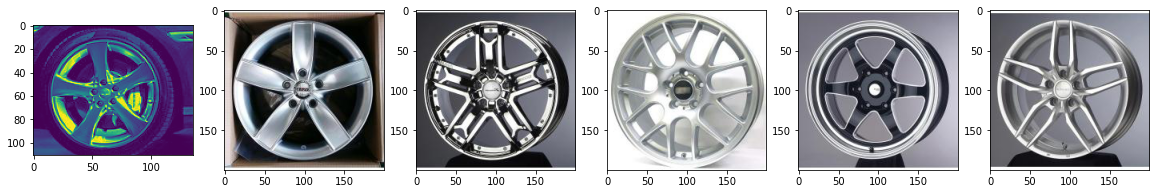

In [ ]:
imgpath="/content/drive/My Drive/2.png"
similar_image(imgpath, wheel_vector1,model2,wheel_pathes)

# 새 섹션

(2063, 2063)
(2063,)
[1560] 0.9342137239435444
[416] 0.9345816733149758
[1813] 0.93582354935144
[1239] 0.9363009995643193
[1632] 0.9502786976129188
[1304] 0.5323628281153462


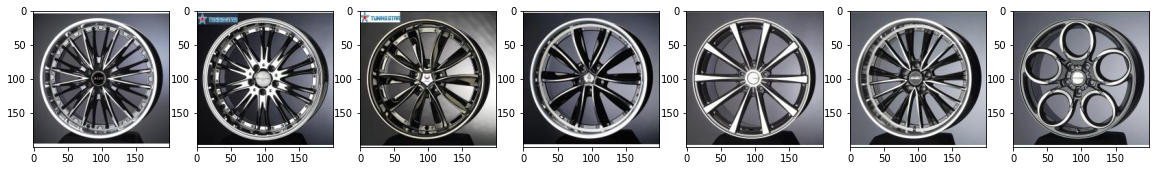

In [ ]:
imgpath=wheel_pathes[1209]
similar_image2(imgpath,wheel_vector2, model2,wheel_pathes)

여기 아래는 adaptive threshold와 monophologyEx의 결과를 보여주는 부분

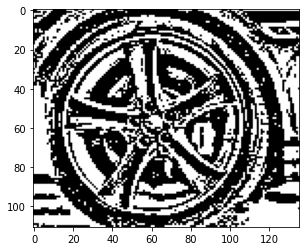

In [ ]:
plt.imshow(threshold("/content/drive/My Drive/2.png"), cmap='gray')
# 레이블을어떻게 붙여줘야 할까..

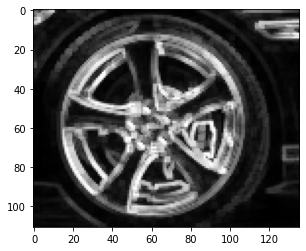

In [ ]:
import cv2
kernel = np.ones((3,3), np.uint8)
#img1 = cv2.imread(wheel_pathes[0])
img2 = cv2.imread("/content/drive/My Drive/2.png")
#img3 = cv2.imread(wheel_pathes[2])
#img1_grad = cv2.morphologyEx(img1, cv2.MORPH_GRADIENT, kernel)
#img1_tophat = cv2.morphologyEx(img1, cv2.MORPH_TOPHAT, kernel)
#img1_blackhat = cv2.morphologyEx(img1, cv2.MORPH_BLACKHAT, kernel)

img2_grad = cv2.morphologyEx(img2, cv2.MORPH_GRADIENT, kernel)
img2_tophat = cv2.morphologyEx(img2, cv2.MORPH_TOPHAT, kernel)
img2_blackhat = cv2.morphologyEx(img2, cv2.MORPH_BLACKHAT, kernel)

#img3_grad = cv2.morphologyEx(img3, cv2.MORPH_GRADIENT, kernel)
#img3_tophat = cv2.morphologyEx(img3, cv2.MORPH_TOPHAT, kernel)
#img3_blackhat = cv2.morphologyEx(img3, cv2.MORPH_BLACKHAT, kernel)

#plt.imshow(img1_grad)
plt.imshow(img2_grad)
#plt.imshow(img3_grad) 